### Libraries

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam

### Settings

In [8]:
### Paths ###

# IP102 path
ip_102_path = "../../../Data/MSiA 432/03_hw/IP102-Dataset/"
ip_102_dir = os.path.join(ip_102_path, 'classification')

# FairFace path
fair_face_path = "../../../Data/MSiA 432/03_hw/FairFace/"

# Question 1

In word document attatched with this submission

# Question 2

In [33]:
# Read classes
with open(os.path.join(ip_102_path, 'classes.txt'), 'r') as f:
    classes = [line.strip().split('\t', 1) for line in f]

# Convert the list to a DataFrame
classes = pd.DataFrame(classes)

# Split the column into two separate columns
classes[[0, 1]] = classes[0].str.split(' ', n=1, expand=True)

# Now you have the class names in column 1 and can drop column 0
classes = classes.drop(columns=[0])
num_classes = classes.shape[0]

print(f"Sample of classes: \n")
print(f"{classes[1].head()}")
print("\n------------------------\n")
print(f"Number of classes: {num_classes}")

Sample of classes: 

0          rice leaf roller
1     rice leaf caterpillar
2         paddy stem maggot
3        asiatic rice borer
4         yellow rice borer
Name: 1, dtype: object

------------------------

Number of classes: 102


In [34]:
# Read the train, test, and validation data
train_df = pd.read_csv(os.path.join(ip_102_path, 'train.txt'), header=None, sep=' ')
test_df = pd.read_csv(os.path.join(ip_102_path, 'test.txt'), header=None, sep=' ')
val_df = pd.read_csv(os.path.join(ip_102_path, 'val.txt'), header=None, sep=' ')

In [35]:
train_df

,0,1
0,00002.jpg,0
1,00003.jpg,0
2,00005.jpg,0
3,00006.jpg,0
4,00008.jpg,0
...,...,...
45090,75212.jpg,101
45091,75214.jpg,101
45092,75216.jpg,101
45093,75217.jpg,101


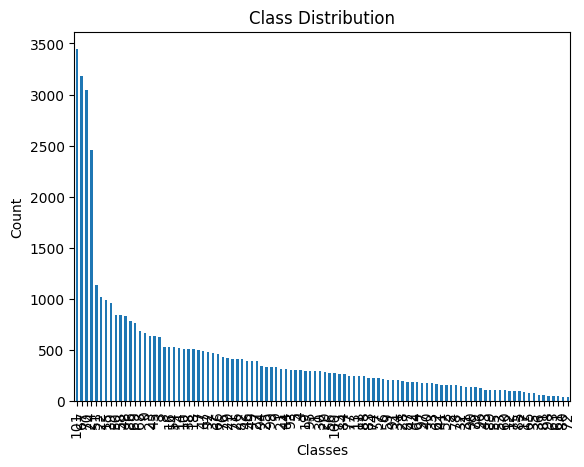

In [36]:
# Plot class distribution
train_df[1].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [38]:
# Define image augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create generators
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(ip_102_dir, 'train'),
    x_col=0,
    y_col=1,
    target_size=(64, 64),
    class_mode='categorical',
    batch_size=32
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(ip_102_dir, 'val'),
    x_col=0,
    y_col=1,
    target_size=(64, 64),
    class_mode='categorical',
    batch_size=32
)

TypeError: If class_mode="categorical", y_col="1" column values must be type string, list or tuple.

In [39]:
# Define the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // 32,
    epochs=10,
    validation_data=val_gen,
    validation_steps=len(val_df) // 32
)

c:\Users\Sam\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


NameError: name 'train_gen' is not defined

# Question 3

# Question 4